# Installing PySpark

In [1]:
%pip install pyspark==3.1.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.0/214.0 MB 4.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 16.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.1.3-py2.py3-none-any.whl size=214463484 sha256=6ce5dc8666f5254b4666c02346f5ed57d1cc92c99618fa15ac7ca86ff5ec2f81
  Stored in directory: /root/.cache/pip/wheels/ad/8e/49/44c110bb8e008d0778c6577d600d46047c6478ecca3f8f1517
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
Note: you may need to restart the kernel to use updated packages.


# Libraries Import

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType
# from pyspark.sql.functions import udf

import numpy as np # linear algebra
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression


# Read Files

## For Kaggle 

In [3]:
INPUT_DIR = '/kaggle/input/walmart-recruiting-store-sales-forecasting'
FEATURES_PATH = './features.csv'
STORES_PATH = './stores.csv'
TEST_PATH = './test.csv'
TRAIN_PATH = './train.csv'
SAMPLE_SUBMISSION_PATH = './sampleSubmission.csv'

!unzip "$INPUT_DIR/*.csv.zip"
!cp "$INPUT_DIR/stores.csv" "/kaggle/working/"
!ls

Archive:  /kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip
  inflating: train.csv               

Archive:  /kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    

Archive:  /kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip
  inflating: features.csv            

Archive:  /kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip
  inflating: test.csv                

4 archives were successfully processed.
__notebook_source__.ipynb  sampleSubmission.csv  test.csv
features.csv		   stores.csv		 train.csv


## Local

In [4]:
# FEATURES_PATH = r'D:\ME\Project\walmart-recruiting-store-sales-forecasting\features.csv'
# STORES_PATH = r'D:\ME\Project\walmart-recruiting-store-sales-forecasting\stores.csv'
# TEST_PATH = r'D:\ME\Project\walmart-recruiting-store-sales-forecasting\test.csv'
# TRAIN_PATH = r'D:\ME\Project\walmart-recruiting-store-sales-forecasting\train.csv'
# SAMPLE_SUBMISSION_PATH = r'D:\ME\Project\walmart-recruiting-store-sales-forecasting\sampleSubmission.csv'

In [5]:
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", '15G') \
        .set("spark.driver.memory", '15G')

spark = SparkSession \
        .builder \
        .appName("WeeklySales-Forecasting-PySpark") \
        .config(conf=conf) \
        .getOrCreate()

22/11/15 10:47:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
# Load datasets
features_raw = spark.read.option("header",True).csv(FEATURES_PATH)
stores_raw = spark.read.option("header",True).csv(STORES_PATH)
train_raw = spark.read.option("header",True).csv(TRAIN_PATH)
test_raw = spark.read.option("header",True).csv(TEST_PATH)
sample_submission = spark.read.option("header",True).csv(SAMPLE_SUBMISSION_PATH)

# Defining Functions

## Metadata

In [7]:
def get_metadata(dataframe):
    cols = dataframe.columns
    print(" STATISTICAL SUMMARY ".center(125, '#'))
    print()
    dataframe.summary().show()
    print(" SCHEMA OF THE DATASET ".center(125, '#'))
    dataframe.printSchema()
    print(" NULL VALUE COUNTS ".center(125, '#'))
    print()
    dataframe.select([count(when(col(c).isNull(), c)).alias(c) for c in cols]).show()
    dup_count = dataframe.count()-dataframe.distinct().count()
    print(f" Number of duplicate Rows : {dup_count} ".center(125, '='))
    print()
    print(' SAMPLE VALUES IN EVERY COLUMN '.center(125, '#'))
    for c in cols:
        print(c)
        col_list = [data[0] for data in dataframe.select(f'{c}').distinct().orderBy(col(f'{c}')).collect()]
        print('Number of Distinct Values : ', len(col_list))
        print(col_list[:100])
    print(" TYPES OF COLUMNS ".center(125, '#'))
    print()
    print("Categorical Columns : ", [item[0] for item in dataframe.dtypes if item[1].startswith('string')])
    print("Numerical Columns: ", [item[0] for item in dataframe.dtypes if (item[1].startswith('integer') | item[1].startswith('double'))])
    print()
    print(" NEGATIVE-VALUED COLUMNS ".center(125, '#'))
    print()
    sql_expressions = [f'count(CASE WHEN ({col} < 0) THEN 1 END) AS {col}_count' for col in cols]
    dataframe.selectExpr(sql_expressions).show()
    print(''.center(125, '#'))

## Holidays

* Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13 
* Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13 
* Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13 
* Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [8]:
def assign_holiday_names(week):
    if week in ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08']:
        return 'SuperBowl Week'
    elif week in ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06']:
        return 'LaborDay Week'
    elif week in ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29']:
        return 'ThanksGiving Week'
    elif week in ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']:
        return 'Christmas'
    else:
        return 'Non-Holiday Week'

In [9]:
# def plot_correlation_matrix(dataframe):
#     vector_col = 'Correlation_Columns'
#     assembler = VectorAssembler(inputCols=dataframe.columns, outputCol=vector_col, handleInvalid = "error")
#     myGraph_vector = assembler.transform(dataframe).select(vector_col)
#     matrix = Correlation.corr(myGraph_vector, vector_col, method='pearson').collect()[0][0]
#     corrmatrix = matrix.toArray().tolist()
#     columns=dataframe.columns
#     fig=plt.figure(figsize=(10,10))
#     ax=fig.add_subplot(111)
#     ax.set_title("Correlation Matrix for Walmart Dataset Features")
#     ax.set_xticklabels(['']+columns)
#     ax.set_yticklabels(['']+columns)
#     cax=ax.matshow(corrmatrix,vmax=1,vmin=-1)
#     fig.colorbar(cax)
#     plt.show()

# EDA

## Features

In [10]:
get_metadata(features_raw)

#################################################### STATISTICAL SUMMARY ####################################################



+-------+---------------+----------+-----------------+-------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+---------+
|summary|          Store|      Date|      Temperature|         Fuel_Price|        MarkDown1|        MarkDown2|         MarkDown3|        MarkDown4|         MarkDown5|               CPI|     Unemployment|IsHoliday|
+-------+---------------+----------+-----------------+-------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+---------+
|  count|           8190|      8190|             8190|               8190|             8190|             8190|              8190|             8190|              8190|              8190|             8190|     8190|
|   mean|           23.0|      null|59.35619780219781| 3.4059918192918217|7032.371785714266|3384.176593632328|1760.1001799058915|3292.9358862586

================================================ Number of duplicate Rows : 0 ===============================================

############################################### SAMPLE VALUES IN EVERY COLUMN ###############################################
Store


Number of Distinct Values :  45
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '5', '6', '7', '8', '9']
Date


Number of Distinct Values :  182
['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26', '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26', '2010-04-02', '2010-04-09', '2010-04-16', '2010-04-23', '2010-04-30', '2010-05-07', '2010-05-14', '2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11', '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09', '2010-07-16', '2010-07-23', '2010-07-30', '2010-08-06', '2010-08-13', '2010-08-20', '2010-08-27', '2010-09-03', '2010-09-10', '2010-09-17', '2010-09-24', '2010-10-01', '2010-10-08', '2010-10-15', '2010-10-22', '2010-10-29', '2010-11-05', '2010-11-12', '2010-11-19', '2010-11-26', '2010-12-03', '2010-12-10', '2010-12-17', '2010-12-24', '2010-12-31', '2011-01-07', '2011-01-14', '2011-01-21', '2011-01-28', '2011-02-04', '2011-02-11', '2011-02-18', '2011-02-25', '2011-03-04', '2011-03-11', '2011-03-18', '2011-03-25', '2011-04-01', '2011-04-08', '2011-04-15', '2011-04-22', '2011-04-29', '2011-05-06', '2011-05-13', '2011-05-20', '2011-05-27', 

Number of Distinct Values :  4178
['-2.06', '-6.08', '-6.61', '-7.29', '0.25', '10.09', '10.11', '10.13', '10.24', '10.53', '10.91', '100.07', '100.14', '101.95', '11.15', '11.17', '11.26', '11.29', '11.32', '11.44', '11.94', '12.05', '12.14', '12.19', '12.27', '12.39', '12.57', '12.98', '13.29', '13.39', '13.43', '13.54', '13.64', '13.73', '13.76', '14.02', '14.19', '14.31', '14.44', '14.48', '14.5', '14.56', '14.64', '14.75', '14.84', '14.94', '15.02', '15.12', '15.2', '15.22', '15.25', '15.33', '15.44', '15.47', '15.56', '15.58', '15.64', '16.27', '16.3', '16.5', '16.57', '16.6', '16.7', '16.81', '16.87', '16.94', '17', '17.05', '17.3', '17.46', '17.56', '17.64', '17.91', '17.93', '17.94', '17.95', '18.12', '18.14', '18.19', '18.2', '18.3', '18.36', '18.49', '18.51', '18.55', '18.57', '18.67', '18.73', '18.75', '18.76', '18.79', '18.8', '18.82', '18.86', '18.89', '18.92', '19.03', '19.05', '19.21', '19.29']
Fuel_Price


Number of Distinct Values :  1011
['2.472', '2.513', '2.514', '2.52', '2.533', '2.539', '2.54', '2.542', '2.545', '2.548', '2.55', '2.561', '2.562', '2.565', '2.567', '2.572', '2.573', '2.574', '2.577', '2.578', '2.58', '2.582', '2.584', '2.586', '2.59', '2.594', '2.595', '2.596', '2.598', '2.601', '2.602', '2.603', '2.604', '2.606', '2.608', '2.612', '2.615', '2.619', '2.62', '2.621', '2.623', '2.624', '2.625', '2.627', '2.633', '2.635', '2.637', '2.64', '2.642', '2.644', '2.645', '2.65', '2.653', '2.654', '2.655', '2.664', '2.666', '2.667', '2.668', '2.669', '2.671', '2.674', '2.68', '2.681', '2.684', '2.689', '2.69', '2.691', '2.692', '2.694', '2.698', '2.699', '2.7', '2.701', '2.704', '2.705', '2.706', '2.707', '2.708', '2.711', '2.712', '2.713', '2.715', '2.716', '2.717', '2.718', '2.719', '2.72', '2.723', '2.725', '2.727', '2.728', '2.729', '2.731', '2.732', '2.733', '2.735', '2.736', '2.737', '2.74']
MarkDown1


Number of Distinct Values :  4024
['-16.93', '-2781.45', '-563.9', '-772.21', '0.27', '0.5', '1.5', '1.94', '10.63', '100.53', '10007.34', '1003.58', '10045.03', '10045.32', '1005.79', '10051.98', '10054.19', '1006.27', '10065.77', '10073.64', '1008.1', '1008.91', '10100.14', '10100.5', '1012.98', '10121.97', '10122.01', '1014.78', '10140.57', '10155.75', '10158.96', '10165.22', '10165.99', '10170.57', '10188.76', '1019.69', '1019.93', '10192.49', '10193.06', '102.49', '1020.44', '1021.83', '10215.77', '1022.5', '10220.45', '1023.4', '1023.6', '10233.14', '1024.31', '1024.83', '10245.25', '1025.38', '10253.67', '10256.46', '10258.3', '10259.59', '10278.27', '10278.48', '10280.65', '10280.97', '10283.49', '10291.35', '10297.42', '10297.71', '103.5', '103.71', '103.81', '10309.58', '10310.26', '10313.25', '103184.98', '10331.04', '10332.93', '10333.24', '10333.55', '10336.01', '1034.72', '10344.3', '10347.04', '10349', '10356.61', '1036.49', '10360.46', '10368.04', '10382.9', '10389.14',

Number of Distinct Values :  2716
['-0.01', '-0.05', '-0.6', '-0.91', '-0.99', '-1.6', '-10.5', '-10.98', '-15.45', '-192', '-2', '-2.5', '-20', '-265.76', '-3.27', '-35.74', '-5.96', '-5.98', '-6.69', '-7.01', '-7.6', '-7.76', '-9.94', '-9.98', '0', '0.01', '0.02', '0.03', '0.04', '0.06', '0.09', '0.1', '0.11', '0.13', '0.15', '0.18', '0.21', '0.24', '0.27', '0.3', '0.33', '0.35', '0.45', '0.5', '0.65', '0.73', '0.75', '0.94', '0.95', '1', '1.02', '1.2', '1.3', '1.41', '1.49', '1.5', '1.53', '1.59', '1.74', '1.75', '1.8', '1.9', '1.91', '1.95', '1.98', '10', '10.3', '10.38', '10.47', '10.5', '10.59', '10.66', '10.78', '10.8', '10.92', '100.54', '1000.19', '1004.38', '101', '101.02', '101.2', '101.3', '101.34', '1010.03', '1010.86', '1011.32', '10126.19', '1014.27', '10140.32', '10149.27', '1015.34', '102.26', '102.32', '102.5', '102.69', '102.74', '102.84', '102.94', '1021.13', '1027.9']
MarkDown3


Number of Distinct Values :  2886
['-0.2', '-0.73', '-0.86', '-0.87', '-1', '-14.29', '-17.44', '-179.26', '-2.58', '-23.97', '-29.1', '-44.54', '-89.1', '0', '0.01', '0.02', '0.04', '0.05', '0.06', '0.09', '0.1', '0.12', '0.13', '0.15', '0.17', '0.18', '0.19', '0.2', '0.22', '0.24', '0.25', '0.26', '0.27', '0.28', '0.3', '0.32', '0.34', '0.35', '0.36', '0.37', '0.4', '0.44', '0.45', '0.46', '0.47', '0.48', '0.49', '0.5', '0.51', '0.52', '0.54', '0.55', '0.57', '0.59', '0.6', '0.63', '0.65', '0.66', '0.68', '0.7', '0.71', '0.72', '0.73', '0.75', '0.76', '0.77', '0.79', '0.8', '0.81', '0.82', '0.85', '0.87', '0.9', '0.92', '0.93', '0.96', '0.98', '0.99', '1', '1.01', '1.02', '1.03', '1.04', '1.05', '1.09', '1.1', '1.12', '1.14', '1.16', '1.17', '1.18', '1.19', '1.2', '1.22', '1.23', '1.24', '1.25', '1.29', '1.3', '1.32']
MarkDown4


Number of Distinct Values :  3406
['0.22', '0.41', '0.46', '0.63', '0.66', '0.78', '0.87', '0.92', '1.26', '1.47', '1.5', '1.56', '1.74', '1.88', '1.89', '1.92', '1.94', '1.98', '10', '10.05', '10.08', '10.16', '10.5', '10.64', '10.88', '100.06', '100.14', '100.86', '1000.2', '1000.8', '1001.42', '1004.51', '10055.75', '1008.3', '1009.78', '10097.26', '101.22', '101.5', '101.57', '1010.06', '1010.3', '1011.45', '1011.54', '1012.3', '1015.44', '1016.11', '1017.09', '1017.31', '1019.28', '1019.9', '102.02', '102.14', '102.38', '1022.91', '10267.54', '1027.37', '10277.08', '1029.14', '103.87', '1030.77', '1032.75', '1035.95', '104.16', '104.18', '104.69', '1040', '1040.74', '10409.34', '10416.2', '1042.41', '1043.37', '10433.78', '10463.07', '1048.83', '1049.44', '105.14', '1050.59', '1051.13', '10514.31', '1053.96', '1054.97', '1056.01', '1057.16', '1057.73', '1059.44', '1059.49', '10597.74', '106.24', '106.35', '106.47', '1060.9', '1061.15', '1066.17', '1066.29', '1067.36', '10671.47', 

Number of Distinct Values :  4046
['-185.17', '-37.02', '10014.8', '1004.04', '1005.06', '1005.13', '1005.18', '1005.33', '1005.65', '1007.44', '1007.61', '1008.38', '1009.26', '1009.98', '1012.91', '1014.35', '10147.9', '1015.16', '1015.8', '10152.27', '1016.84', '1016.91', '1017.39', '10170.5', '1018.23', '10189.75', '1019.91', '10204.37', '1021.09', '10223.2', '10231.67', '10232.63', '1024.72', '1024.9', '1025.77', '1026.11', '10261.95', '1027.88', '10273.98', '10296.01', '1030.33', '10303.93', '10309.95', '1031.3', '1031.37', '1032.15', '1032.44', '10335.05', '1034.55', '10349.85', '10351.49', '1037.07', '10377.32', '1038.01', '10380.03', '1039.34', '10397.55', '1040.07', '1040.96', '1041.62', '1042.83', '10421.01', '1043.07', '10430.56', '1044.74', '1044.93', '1045.15', '1046.13', '1046.14', '10462.74', '10483.58', '10484.98', '10488.23', '1049.36', '1049.91', '1050.13', '1050.29', '1050.85', '10506.12', '1051.35', '1051.49', '1052.94', '105223.11', '10538.44', '10557.13', '1057.3

Number of Distinct Values :  2506
['126.064', '126.0766452', '126.0854516', '126.0892903', '126.1019355', '126.1069032', '126.1119032', '126.114', '126.1145806', '126.1266', '126.1283548', '126.1360645', '126.1392', '126.1454667', '126.1498065', '126.1518', '126.1602258', '126.1843871', '126.1900333', '126.2085484', '126.2346', '126.2791667', '126.2898', '126.3266774', '126.3805667', '126.3815484', '126.4364194', '126.4420645', '126.4713333', '126.4912903', '126.4962581', '126.5262857', '126.5461613', '126.5522857', '126.5621', '126.5782857', '126.6019032', '126.6034839', '126.6042857', '126.6050645', '126.6066452', '126.6072', '126.6692667', '126.7313333', '126.7934', '126.8794839', '126.9835806', '127.0876774', '127.1917742', '127.3009355', '127.4404839', '127.5800323', '127.7195806', '127.859129', '127.99525', '128.13', '128.26475', '128.3995', '128.5121935', '128.6160645', '128.7199355', '128.8238065', '128.9107333', '128.9553', '128.9998667', '129.0357097', '129.0432', '129.044433

Number of Distinct Values :  405
['10.064', '10.115', '10.148', '10.16', '10.199', '10.21', '10.256', '10.398', '10.409', '10.524', '10.581', '10.641', '10.926', '11.627', '12.187', '12.89', '13.503', '13.736', '13.975', '14.021', '14.099', '14.18', '14.313', '3.684', '3.879', '3.896', '3.921', '3.932', '4.077', '4.125', '4.145', '4.156', '4.261', '4.308', '4.42', '4.584', '4.607', '4.781', '4.872', '4.893', '4.954', '4.983', '5.024', '5.049', '5.114', '5.124', '5.143', '5.212', '5.213', '5.217', '5.274', '5.275', '5.277', '5.278', '5.285', '5.287', '5.324', '5.326', '5.329', '5.372', '5.401', '5.407', '5.415', '5.422', '5.435', '5.494', '5.527', '5.539', '5.603', '5.621', '5.639', '5.644', '5.667', '5.668', '5.679', '5.765', '5.771', '5.774', '5.801', '5.825', '5.847', '5.892', '5.936', '5.943', '5.946', '5.964', '5.965', '5.999', '6.034', '6.054', '6.061', '6.078', '6.104', '6.108', '6.112', '6.123', '6.132', '6.143', '6.162', '6.169']
IsHoliday
Number of Distinct Values :  2
['FALSE

In [11]:
features_df = features_raw.select(col('Store').cast('int'), \
                                  col('Date').cast('date'), \
                                  col('Temperature').cast('float'), \
                                  col('Fuel_Price').cast('float'), \
                                  col('MarkDown1').cast('float'), \
                                  col('MarkDown2').cast('float'), \
                                  col('MarkDown3').cast('float'), \
                                  col('MarkDown4').cast('float'), \
                                  col('MarkDown5').cast('float'), \
                                  col('CPI').cast('float'), \
                                  col('Unemployment').cast('float'), \
                                  col('IsHoliday'))
features_df

DataFrame[Store: int, Date: date, Temperature: float, Fuel_Price: float, MarkDown1: float, MarkDown2: float, MarkDown3: float, MarkDown4: float, MarkDown5: float, CPI: float, Unemployment: float, IsHoliday: string]

## Stores

In [12]:
get_metadata(stores_raw)

#################################################### STATISTICAL SUMMARY ####################################################

+-------+------------------+----+-----------------+
|summary|             Store|Type|             Size|
+-------+------------------+----+-----------------+
|  count|                45|  45|               45|
|   mean|              23.0|null|         130287.6|
| stddev|13.133925536563698|null|63825.27199115923|
|    min|                 1|   A|           103681|
|    25%|              12.0|null|          70713.0|
|    50%|              23.0|null|         126512.0|
|    75%|              34.0|null|         202307.0|
|    max|                 9|   C|            93638|
+-------+------------------+----+-----------------+

################################################### SCHEMA OF THE DATASET ###################################################
root
 |-- Store: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: string (nullable = true)

#######

================================================ Number of duplicate Rows : 0 ===============================================

############################################### SAMPLE VALUES IN EVERY COLUMN ###############################################
Store


Number of Distinct Values :  45
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '5', '6', '7', '8', '9']
Type
Number of Distinct Values :  3
['A', 'B', 'C']
Size
Number of Distinct Values :  40
['103681', '112238', '114533', '118221', '119557', '120653', '123737', '125833', '126512', '128107', '140167', '151315', '152513', '155078', '155083', '158114', '184109', '196321', '200898', '202307', '202505', '203007', '203742', '203750', '203819', '204184', '205863', '206302', '207499', '219622', '34875', '37392', '39690', '39910', '41062', '42988', '57197', '70713', '93188', '93638']
###################################################### TYPES OF COLUMNS #####################################################

Categorical Columns :  ['Store', 'Type', 'Size']
Numerical Columns:  []

##########################

In [13]:
stores_df = stores_raw.select(col('Store').cast('int'), \
                              col('Type'), \
                              col('Size').cast('float'))
stores_df

DataFrame[Store: int, Type: string, Size: float]

In [14]:
stores_df.groupBy('Type').agg(min(col('Size')), max(col('Size'))).distinct().orderBy('Type').show()

+----+---------+---------+
|Type|min(Size)|max(Size)|
+----+---------+---------+
|   A|  39690.0| 219622.0|
|   B|  34875.0| 140167.0|
|   C|  39690.0|  42988.0|
+----+---------+---------+



In [15]:
# Check for Missing Stores
print(f'Missing Stores: {train_raw[["Store"]].distinct().count() != features_raw[["Store"]].distinct().count()}')

Missing Stores: False


In [16]:
features_raw[["Store"]].distinct().count()

45

## Train

In [17]:
get_metadata(train_raw)

#################################################### STATISTICAL SUMMARY ####################################################



+-------+------------------+-----------------+----------+-----------------+---------+
|summary|             Store|             Dept|      Date|     Weekly_Sales|IsHoliday|
+-------+------------------+-----------------+----------+-----------------+---------+
|  count|            421570|           421570|    421570|           421570|   421570|
|   mean|22.200545579619043|44.26031738501317|      null|15981.25812346749|     null|
| stddev|12.785297389902897|30.49205401578606|      null|22711.18351916322|     null|
|    min|                 1|                1|2010-02-05|            -0.02|    FALSE|
|    25%|              11.0|             18.0|      null|          2079.39|     null|
|    50%|              22.0|             37.0|      null|          7612.59|     null|
|    75%|              33.0|             74.0|      null|          20201.0|     null|
|    max|                 9|               99|2012-10-26|         99998.65|     TRUE|
+-------+------------------+-----------------+--------

================================================ Number of duplicate Rows : 0 ===============================================

############################################### SAMPLE VALUES IN EVERY COLUMN ###############################################
Store
Number of Distinct Values :  45
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '5', '6', '7', '8', '9']
Dept
Number of Distinct Values :  81
['1', '10', '11', '12', '13', '14', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '54', '55', '56', '58', '59', '6', '60', '65', '67', '7', '71', '72', '74', '77', '78', '79', '8', '80', '81', '82', '83', '85', '87

Number of Distinct Values :  143
['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26', '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26', '2010-04-02', '2010-04-09', '2010-04-16', '2010-04-23', '2010-04-30', '2010-05-07', '2010-05-14', '2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11', '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09', '2010-07-16', '2010-07-23', '2010-07-30', '2010-08-06', '2010-08-13', '2010-08-20', '2010-08-27', '2010-09-03', '2010-09-10', '2010-09-17', '2010-09-24', '2010-10-01', '2010-10-08', '2010-10-15', '2010-10-22', '2010-10-29', '2010-11-05', '2010-11-12', '2010-11-19', '2010-11-26', '2010-12-03', '2010-12-10', '2010-12-17', '2010-12-24', '2010-12-31', '2011-01-07', '2011-01-14', '2011-01-21', '2011-01-28', '2011-02-04', '2011-02-11', '2011-02-18', '2011-02-25', '2011-03-04', '2011-03-11', '2011-03-18', '2011-03-25', '2011-04-01', '2011-04-08', '2011-04-15', '2011-04-22', '2011-04-29', '2011-05-06', '2011-05-13', '2011-05-20', '2011-05-27', 

Number of Distinct Values :  359464
['-0.02', '-0.04', '-0.07', '-0.08', '-0.1', '-0.12', '-0.2', '-0.24', '-0.26', '-0.27', '-0.29', '-0.36', '-0.37', '-0.4', '-0.43', '-0.5', '-0.56', '-0.6', '-0.63', '-0.64', '-0.65', '-0.66', '-0.7', '-0.72', '-0.75', '-0.76', '-0.79', '-0.85', '-0.86', '-0.9', '-0.92', '-0.93', '-0.95', '-0.96', '-0.97', '-0.98', '-1', '-1.03', '-1.1', '-1.13', '-1.16', '-1.18', '-1.21', '-1.23', '-1.25', '-1.27', '-1.33', '-1.35', '-1.36', '-1.37', '-1.4', '-1.47', '-1.48', '-1.5', '-1.52', '-1.53', '-1.56', '-1.59', '-1.61', '-1.66', '-1.72', '-1.77', '-1.78', '-1.8', '-1.84', '-1.85', '-1.88', '-1.9', '-1.91', '-1.94', '-1.96', '-1.97', '-1.98', '-10', '-10.02', '-10.04', '-10.21', '-10.38', '-10.47', '-10.5', '-10.54', '-10.56', '-10.64', '-10.68', '-10.88', '-10.9', '-10.92', '-10.96', '-10.97', '-100', '-1008.96', '-101.26', '-102.32', '-103', '-103.06', '-106.34', '-107.72', '-108', '-109', '-1098']
IsHoliday
Number of Distinct Values :  2
['FALSE', 'TRUE']

In [18]:
train_df = train_raw.select(col('Store').cast('int'), col('Dept').cast('int'), col('Date').cast('date'), col('Weekly_Sales').cast('float'), col('IsHoliday'))
train_df

DataFrame[Store: int, Dept: int, Date: date, Weekly_Sales: float, IsHoliday: string]

## Test

In [19]:
get_metadata(test_raw)

#################################################### STATISTICAL SUMMARY ####################################################



+-------+------------------+------------------+----------+---------+
|summary|             Store|              Dept|      Date|IsHoliday|
+-------+------------------+------------------+----------+---------+
|  count|            115064|            115064|    115064|   115064|
|   mean|  22.2382065633039| 44.33952409094069|      null|     null|
| stddev|12.809929591378935|30.656410130030174|      null|     null|
|    min|                 1|                 1|2012-11-02|    FALSE|
|    25%|              11.0|              18.0|      null|     null|
|    50%|              22.0|              37.0|      null|     null|
|    75%|              33.0|              74.0|      null|     null|
|    max|                 9|                99|2013-07-26|     TRUE|
+-------+------------------+------------------+----------+---------+

################################################### SCHEMA OF THE DATASET ###################################################
root
 |-- Store: string (nullable = true)
 |-

In [20]:
test_df = test_raw.select(col('Store').cast('int'), col('Dept').cast('int'), col('Date').cast('date'), col('IsHoliday'))
# test_df.show()

# Pre-processing

## Joining Data

In [21]:
train = train_df.join(stores_df, on=(['Store']), how='inner') \
                .join(features_df, on=(['Store', 'Date', 'IsHoliday']), how='inner')
train.show(3)

+-----+----------+---------+----+------------+----+--------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Type|    Size|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|      CPI|Unemployment|
+-----+----------+---------+----+------------+----+--------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+
|    1|2010-02-05|    FALSE|   1|     24924.5|   A|151315.0|      42.31|     2.572|     null|     null|     null|     null|     null|211.09636|       8.106|
|    1|2010-02-12|     TRUE|   1|    46039.49|   A|151315.0|      38.51|     2.548|     null|     null|     null|     null|     null|211.24217|       8.106|
|    1|2010-02-19|    FALSE|   1|    41595.55|   A|151315.0|      39.93|     2.514|     null|     null|     null|     null|     null|211.28914|       8.106|
+-----+----------+---------+----+------------+----+-------

In [22]:
test = test_df.join(stores_df, on=(['Store']), how='inner') \
                .join(features_df, on=(['Store', 'Date', 'IsHoliday']), how='inner')
# test.show()

## Filling null Values

In [23]:
train_data = train.fillna(0, subset=['Markdown1', 'Markdown2', 'Markdown3', 'Markdown4', 'Markdown5'])
# train_data.show()

In [24]:
test_data = test.fillna(0, subset=['Markdown1', 'Markdown2', 'Markdown3', 'Markdown4', 'Markdown5'])
# test_data.show()

## Negative Values

In [25]:
train_data.selectExpr([f'count(CASE WHEN ({col} < 0) THEN 1 END) AS {col}_count' for col in train_data.select('Weekly_Sales', 'Markdown1', 'Markdown2', 'Markdown3', 'Markdown4', 'Markdown5').columns]).show()

+------------------+---------------+---------------+---------------+---------------+---------------+
|Weekly_Sales_count|Markdown1_count|Markdown2_count|Markdown3_count|Markdown4_count|Markdown5_count|
+------------------+---------------+---------------+---------------+---------------+---------------+
|              1285|              0|           1311|            257|              0|              0|
+------------------+---------------+---------------+---------------+---------------+---------------+



In [26]:
train_data_ = train_data.withColumn('Weekly_Sales', when(col('Weekly_Sales') < 0, 0).otherwise(col('Weekly_Sales'))) \
                        .withColumn('Markdown2', when(col('Markdown2') < 0, 0).otherwise(col('Markdown2'))) \
                        .withColumn('Markdown3', when(col('Markdown3') < 0, 0).otherwise(col('Markdown3'))) 
train_data_.show()

+-----+----------+---------+----+------------+----+--------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Type|    Size|Temperature|Fuel_Price|MarkDown1|Markdown2|Markdown3|MarkDown4|MarkDown5|      CPI|Unemployment|
+-----+----------+---------+----+------------+----+--------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+
|    1|2010-02-05|    FALSE|   1|     24924.5|   A|151315.0|      42.31|     2.572|      0.0|      0.0|      0.0|      0.0|      0.0|211.09636|       8.106|
|    1|2010-02-12|     TRUE|   1|    46039.49|   A|151315.0|      38.51|     2.548|      0.0|      0.0|      0.0|      0.0|      0.0|211.24217|       8.106|
|    1|2010-02-19|    FALSE|   1|    41595.55|   A|151315.0|      39.93|     2.514|      0.0|      0.0|      0.0|      0.0|      0.0|211.28914|       8.106|
|    1|2010-02-26|    FALSE|   1|    19403.54|   A|151315.

In [27]:
train_data_.selectExpr([f'count(CASE WHEN ({col} < 0) THEN 1 END) AS {col}_count' for col in train_data.select('Weekly_Sales', 'Markdown1', 'Markdown2', 'Markdown3', 'Markdown4', 'Markdown5').columns]).show()

+------------------+---------------+---------------+---------------+---------------+---------------+
|Weekly_Sales_count|Markdown1_count|Markdown2_count|Markdown3_count|Markdown4_count|Markdown5_count|
+------------------+---------------+---------------+---------------+---------------+---------------+
|                 0|              0|              0|              0|              0|              0|
+------------------+---------------+---------------+---------------+---------------+---------------+



In [28]:
test_data.selectExpr([f'count(CASE WHEN ({col} < 0) THEN 1 END) AS {col}_count' for col in test_data.select('Markdown1', 'Markdown2', 'Markdown3', 'Markdown4', 'Markdown5').columns]).show()

+---------------+---------------+---------------+---------------+---------------+
|Markdown1_count|Markdown2_count|Markdown3_count|Markdown4_count|Markdown5_count|
+---------------+---------------+---------------+---------------+---------------+
|            207|            412|            589|              0|            136|
+---------------+---------------+---------------+---------------+---------------+



In [29]:
test_data_ = test_data.withColumn('Markdown1', when(col('Markdown1') < 0, 0).otherwise(col('Markdown1'))) \
                        .withColumn('Markdown2', when(col('Markdown2') < 0, 0).otherwise(col('Markdown2'))) \
                        .withColumn('Markdown3', when(col('Markdown3') < 0, 0).otherwise(col('Markdown3'))) \
                        .withColumn('Markdown5', when(col('Markdown5') < 0, 0).otherwise(col('Markdown5')))

In [30]:
test_data_.selectExpr([f'count(CASE WHEN ({col} < 0) THEN 1 END) AS {col}_count' for col in test_data.select('Markdown1', 'Markdown2', 'Markdown3', 'Markdown4', 'Markdown5').columns]).show()

+---------------+---------------+---------------+---------------+---------------+
|Markdown1_count|Markdown2_count|Markdown3_count|Markdown4_count|Markdown5_count|
+---------------+---------------+---------------+---------------+---------------+
|              0|              0|              0|              0|              0|
+---------------+---------------+---------------+---------------+---------------+



## Detecting Outliers

In [31]:
pd_train = train_data_.toPandas()

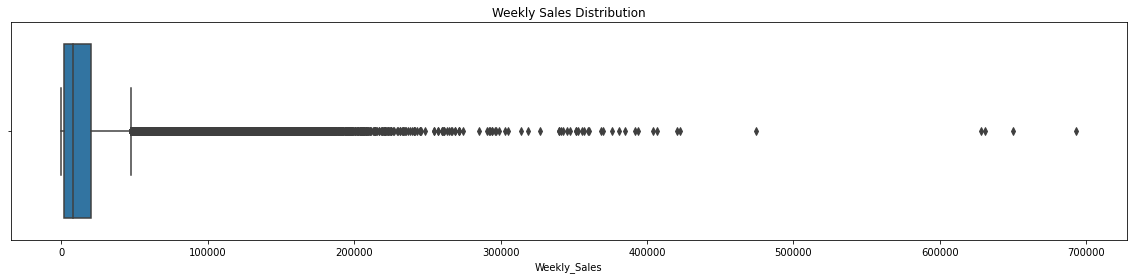

In [32]:
plt.figure(figsize=(20,4))
plt.title('Weekly Sales Distribution')
sns.boxplot(data=pd_train, x='Weekly_Sales')
plt.show()

# Feature Engineering

In [33]:
# HolidayUDF = udf(lambda week: assign_holiday_names(week))

## Holiday References

In [34]:
train_data_f = train_data_.withColumn('Year', year('Date')) \
    .withColumn('Month', month('Date')) \
    .withColumn('Week', weekofyear('Date')) \
    .withColumn('Date_', train_data['Date'].cast('string'))  \
    .withColumn('Holiday_ref', \
        when((col('Date_') == lit('2010-02-12')) | (col('Date_') == lit('2011-02-11')) | (col('Date_') == lit('2012-02-10')) | (col('Date_') == lit('2013-02-08')), 'SuperBowl Week') \
        .when((col('Date_') == lit('2010-09-10')) | (col('Date_') == lit('2011-09-09')) | (col('Date_') == lit('2012-09-07')) | (col('Date_') == lit('2013-09-06')), 'LaborDay Week') \
        .when((col('Date_') == lit('2010-11-26')) | (col('Date_') == lit('2011-11-25')) | (col('Date_') == lit('2012-11-23')) | (col('Date_') == lit('2013-11-29')), 'ThanksGiving Week') \
        .when((col('Date_') == lit('2010-12-31')) | (col('Date_') == lit('2011-12-30')) | (col('Date_') == lit('2012-12-28')) | (col('Date_') == lit('2013-12-27')), 'Christmas Week') \
        .otherwise('Non-Holiday Week'))
train_data_f.show()

+-----+----------+---------+----+------------+----+--------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+----+-----+----+----------+----------------+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Type|    Size|Temperature|Fuel_Price|MarkDown1|Markdown2|Markdown3|MarkDown4|MarkDown5|      CPI|Unemployment|Year|Month|Week|     Date_|     Holiday_ref|
+-----+----------+---------+----+------------+----+--------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+----+-----+----+----------+----------------+
|    1|2010-02-05|    FALSE|   1|     24924.5|   A|151315.0|      42.31|     2.572|      0.0|      0.0|      0.0|      0.0|      0.0|211.09636|       8.106|2010|    2|   5|2010-02-05|Non-Holiday Week|
|    1|2010-02-12|     TRUE|   1|    46039.49|   A|151315.0|      38.51|     2.548|      0.0|      0.0|      0.0|      0.0|      0.0|211.24217|       8.106|2010|    2|   6|2010-02-12|  SuperBowl W

In [35]:
test_data_f = test_data_.withColumn('Year', year('Date')) \
    .withColumn('Month', month('Date')) \
    .withColumn('Week', weekofyear('Date')) \
    .withColumn('Date_', test_data['Date'].cast('string'))  \
    .withColumn('Holiday_ref', \
        when((col('Date_') == lit('2010-02-12')) | (col('Date_') == lit('2011-02-11')) | (col('Date_') == lit('2012-02-10')) | (col('Date_') == lit('2013-02-08')), 'SuperBowl Week') \
        .when((col('Date_') == lit('2010-09-10')) | (col('Date_') == lit('2011-09-09')) | (col('Date_') == lit('2012-09-07')) | (col('Date_') == lit('2013-09-06')), 'LaborDay Week') \
        .when((col('Date_') == lit('2010-11-26')) | (col('Date_') == lit('2011-11-25')) | (col('Date_') == lit('2012-11-23')) | (col('Date_') == lit('2013-11-29')), 'ThanksGiving Week') \
        .when((col('Date_') == lit('2010-12-31')) | (col('Date_') == lit('2011-12-30')) | (col('Date_') == lit('2012-12-28')) | (col('Date_') == lit('2013-12-27')), 'Christmas Week') \
        .otherwise('Non-Holiday Week'))
test_data_f.show()

+-----+----------+---------+----+----+--------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+----+-----+----+----------+-----------------+
|Store|      Date|IsHoliday|Dept|Type|    Size|Temperature|Fuel_Price|Markdown1|Markdown2|Markdown3|MarkDown4|Markdown5|      CPI|Unemployment|Year|Month|Week|     Date_|      Holiday_ref|
+-----+----------+---------+----+----+--------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+----+-----+----+----------+-----------------+
|    1|2012-11-02|    FALSE|   1|   A|151315.0|      55.32|     3.386|  6766.44|   5147.7|    50.82|   3639.9|  2737.42|223.46278|       6.573|2012|   11|  44|2012-11-02| Non-Holiday Week|
|    1|2012-11-09|    FALSE|   1|   A|151315.0|      61.24|     3.314| 11421.32|  3370.89|    40.28|  4646.79|  6154.16|223.48131|       6.573|2012|   11|  45|2012-11-09| Non-Holiday Week|
|    1|2012-11-16|    FALSE|   1|   A|151315.0|      52

## Markdown

In [36]:
train_data_md = train_data_f.withColumn('Markdown', (col('Markdown1')+col('Markdown2')+col('Markdown3')+col('Markdown4')+col('Markdown5'))/5) \
    .drop('Markdown1', 'Markdown2', 'Markdown3', 'Markdown4', 'Markdown5')
train_data_md.show()

+-----+----------+---------+----+------------+----+--------+-----------+----------+---------+------------+----+-----+----+----------+----------------+--------+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Type|    Size|Temperature|Fuel_Price|      CPI|Unemployment|Year|Month|Week|     Date_|     Holiday_ref|Markdown|
+-----+----------+---------+----+------------+----+--------+-----------+----------+---------+------------+----+-----+----+----------+----------------+--------+
|    1|2010-02-05|    FALSE|   1|     24924.5|   A|151315.0|      42.31|     2.572|211.09636|       8.106|2010|    2|   5|2010-02-05|Non-Holiday Week|     0.0|
|    1|2010-02-12|     TRUE|   1|    46039.49|   A|151315.0|      38.51|     2.548|211.24217|       8.106|2010|    2|   6|2010-02-12|  SuperBowl Week|     0.0|
|    1|2010-02-19|    FALSE|   1|    41595.55|   A|151315.0|      39.93|     2.514|211.28914|       8.106|2010|    2|   7|2010-02-19|Non-Holiday Week|     0.0|
|    1|2010-02-26|    FALSE|   1|    194

In [37]:
test_data_md = test_data_f.withColumn('Markdown', (col('Markdown1')+col('Markdown2')+col('Markdown3')+col('Markdown4')+col('Markdown5'))/5) \
    .drop('Markdown1', 'Markdown2', 'Markdown3', 'Markdown4', 'Markdown5')
test_data_md.show(2)

+-----+----------+---------+----+----+--------+-----------+----------+---------+------------+----+-----+----+----------+----------------+-------------+
|Store|      Date|IsHoliday|Dept|Type|    Size|Temperature|Fuel_Price|      CPI|Unemployment|Year|Month|Week|     Date_|     Holiday_ref|     Markdown|
+-----+----------+---------+----+----+--------+-----------+----------+---------+------------+----+-----+----+----------+----------------+-------------+
|    1|2012-11-02|    FALSE|   1|   A|151315.0|      55.32|     3.386|223.46278|       6.573|2012|   11|  44|2012-11-02|Non-Holiday Week|   3668.45625|
|    1|2012-11-09|    FALSE|   1|   A|151315.0|      61.24|     3.314|223.48131|       6.573|2012|   11|  45|2012-11-09|Non-Holiday Week|5126.68828125|
+-----+----------+---------+----+----+--------+-----------+----------+---------+------------+----+-----+----+----------+----------------+-------------+
only showing top 2 rows



## Dropping Unnecessary Columns

In [38]:
train_pp = train_data_md.drop('Date', 'IsHoliday', 'Type', 'Date_')
test_pp = test_data_md.drop('Date', 'IsHoliday', 'Type', 'Date_')

In [39]:
train_pp.show(2)

+-----+----+------------+--------+-----------+----------+---------+------------+----+-----+----+----------------+--------+
|Store|Dept|Weekly_Sales|    Size|Temperature|Fuel_Price|      CPI|Unemployment|Year|Month|Week|     Holiday_ref|Markdown|
+-----+----+------------+--------+-----------+----------+---------+------------+----+-----+----+----------------+--------+
|    1|   1|     24924.5|151315.0|      42.31|     2.572|211.09636|       8.106|2010|    2|   5|Non-Holiday Week|     0.0|
|    1|   1|    46039.49|151315.0|      38.51|     2.548|211.24217|       8.106|2010|    2|   6|  SuperBowl Week|     0.0|
+-----+----+------------+--------+-----------+----------+---------+------------+----+-----+----+----------------+--------+
only showing top 2 rows



## Plots

In [40]:
pd_train = train_pp.toPandas()

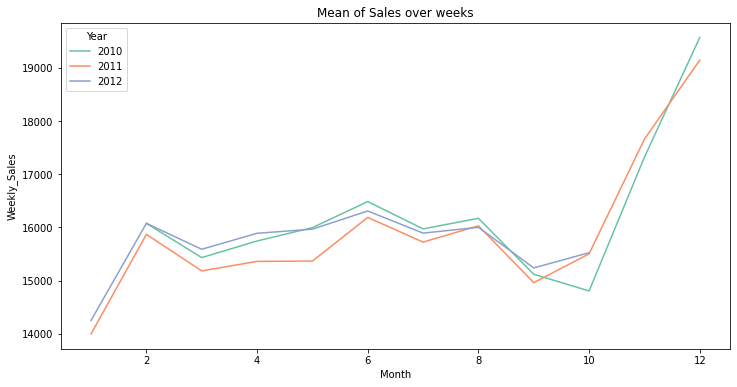

In [41]:
plt.figure(figsize=(12,6))
plt.title('Mean of Sales over weeks')
sns.lineplot(data=pd_train, x='Month', y='Weekly_Sales', hue='Year', estimator='mean', ci=None, palette='Set2')
plt.show()

Average Sales is higher in November and December during all the years(2010, 2011, 2012)

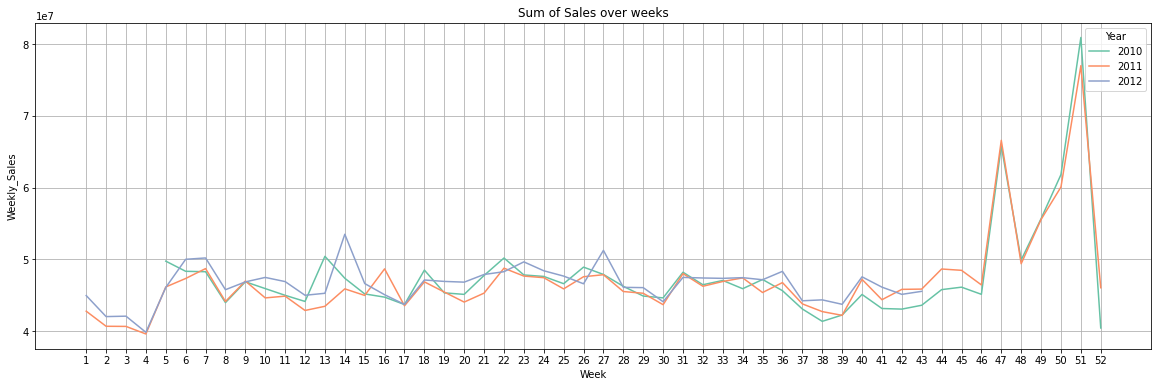

In [42]:
plt.figure(figsize=(20,6))
plt.title('Sum of Sales over weeks')
sns.lineplot(data=pd_train, x='Week', y='Weekly_Sales', hue='Year', estimator='sum', ci=None, palette='Set2')
plt.xticks(np.arange(1,53))
plt.grid()
plt.show()

47th Week and 51st Week show Higher Sales(Drastic Peak)

In [43]:
train_pp.filter(col('Holiday_ref')!='Non-Holiday Week').select('Week', 'Holiday_ref').distinct().orderBy('Week').show()

+----+-----------------+
|Week|      Holiday_ref|
+----+-----------------+
|   6|   SuperBowl Week|
|  36|    LaborDay Week|
|  47|ThanksGiving Week|
|  52|   Christmas Week|
+----+-----------------+



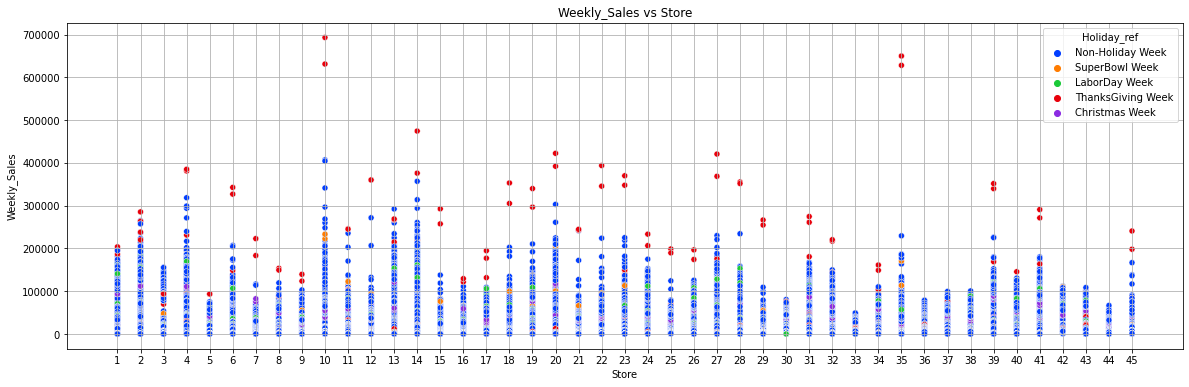

In [44]:
plt.figure(figsize=(20,6))
plt.title('Weekly_Sales vs Store')
# sns.set(style='whitegrid')
sns.scatterplot(x='Store', y='Weekly_Sales', hue='Holiday_ref', data=pd_train, palette='bright') # Weekly_Sales -> 0.3 =30L
plt.xticks(np.arange(1,46))
plt.grid()
plt.show()

Inferences:
* The Sales are higher during ThanksGiving Week in most of the Store 
* Store 33 has very Negligibly Very Low Sale

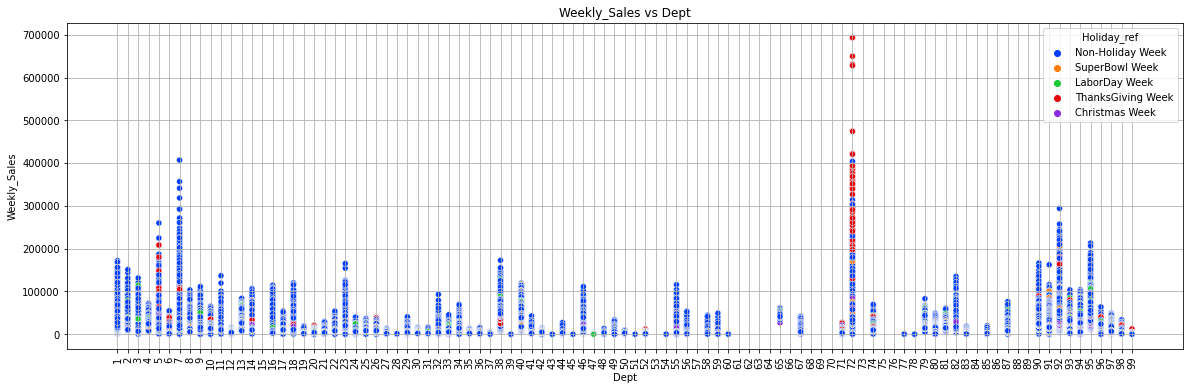

In [45]:
plt.figure(figsize=(20,6))
plt.title('Weekly_Sales vs Dept')
# sns.set(style='whitegrid')
sns.scatterplot(x='Dept', y='Weekly_Sales', hue='Holiday_ref', data=pd_train, palette='bright') # Weekly_Sales -> 0.3 =30L
plt.xticks(np.arange(1,100), rotation=90)
plt.grid()
plt.show()

Inferences:  
* Dept 72 has the most Sales 
* Dept 7 has most Sales during Non-Holiday Week
* Dept 15, 53, 61, 62, 63, 64, 68, 69, 70, 75, 76, 84, 88 and 89 has NO SALES

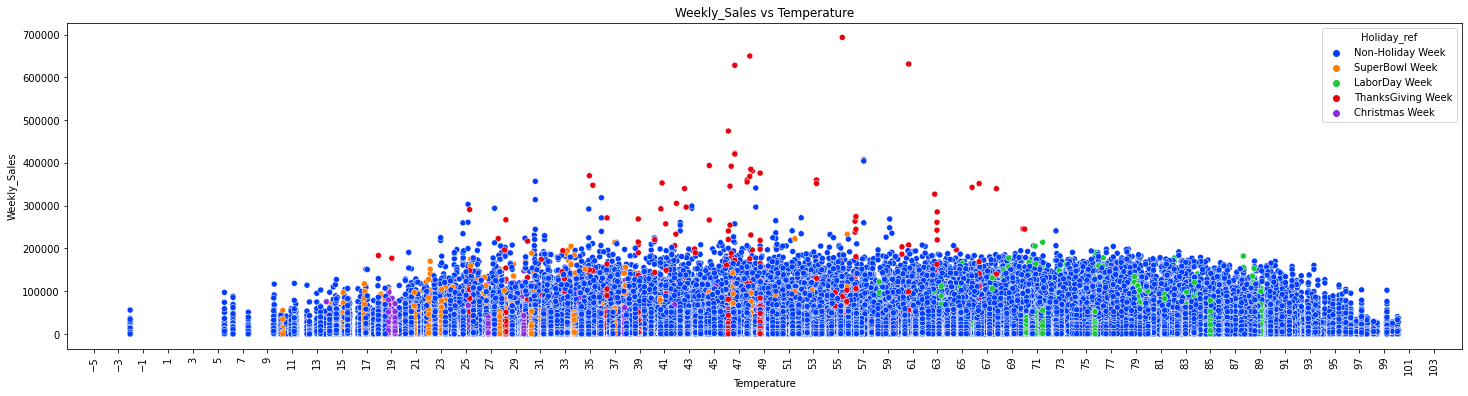

In [46]:
plt.figure(figsize=(25,6))
plt.title('Weekly_Sales vs Temperature')
# sns.set(style='whitegrid')
sns.scatterplot(x='Temperature', y='Weekly_Sales', hue='Holiday_ref', data=pd_train, palette='bright') # Weekly_Sales -> 0.3 =30L
plt.xticks(np.arange(-5,105, step=2), rotation=90)
plt.show()

Inferences: 
* There are Sales when Temperature is -2degree Celsius
* Sales drop when the Temperature is Low(between -5degree and +20degree) and High(> +95degrees)

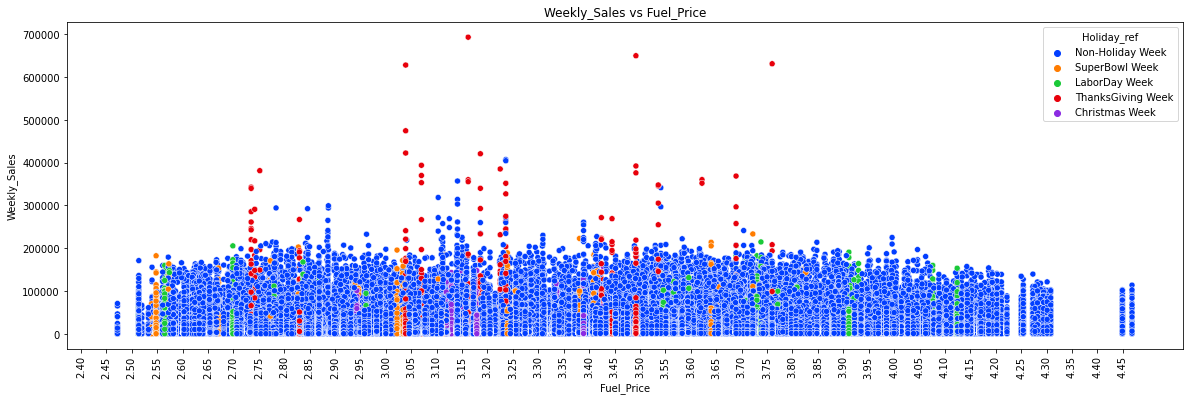

In [47]:
plt.figure(figsize=(20,6))
plt.title('Weekly_Sales vs Fuel_Price')
# sns.set(style='whitegrid')
sns.scatterplot(x='Fuel_Price', y='Weekly_Sales', hue='Holiday_ref', data=pd_train, palette='bright') # Weekly_Sales -> 0.3 =30L
plt.xticks(np.arange(2.4,4.5, step=0.05), rotation=90)
plt.show()

Inference:
* When Fuel Price is higher than 4.20, the Sales are Lesser

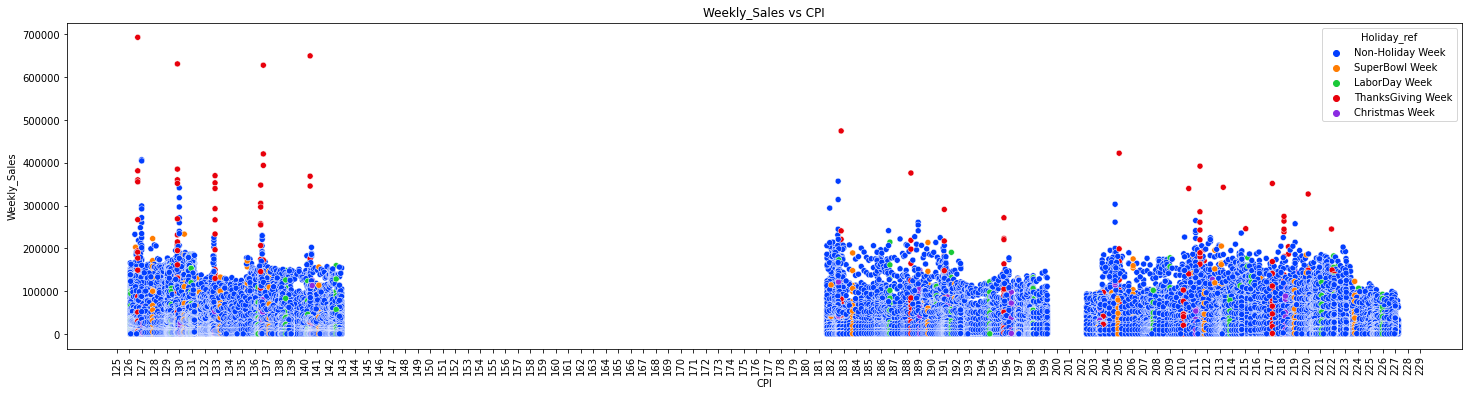

In [48]:
plt.figure(figsize=(25,6))
plt.title('Weekly_Sales vs CPI')
# sns.set(style='whitegrid')
sns.scatterplot(x='CPI', y='Weekly_Sales', hue='Holiday_ref', data=pd_train, palette='bright') # Weekly_Sales -> 0.3 =30L
plt.xticks(np.arange(125,230, step=1), rotation=90)
plt.show()

Inference:
* Even if the CPI is higher, the Sales are more - CPI does not affect the Sales

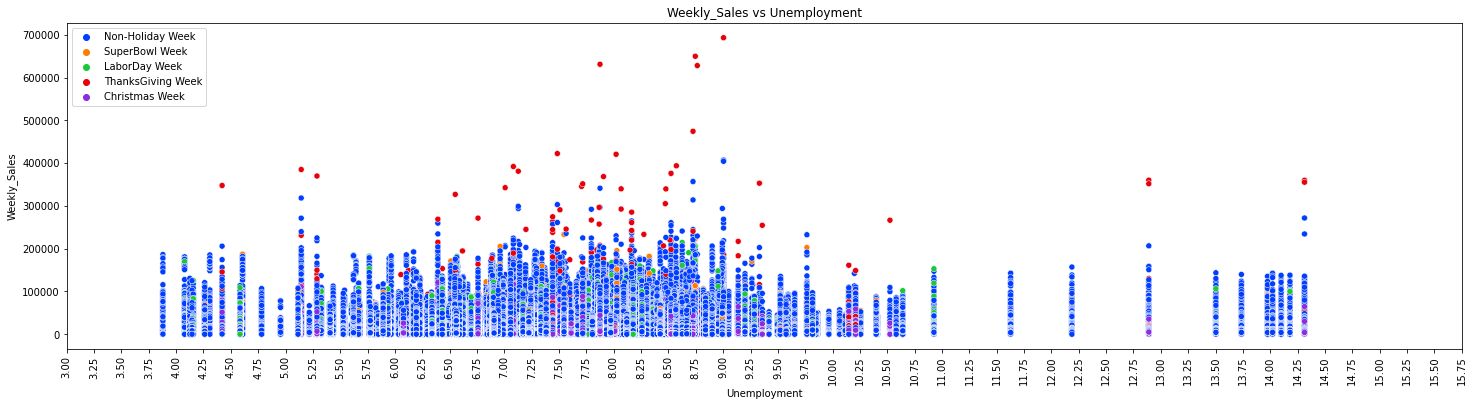

In [49]:
plt.figure(figsize=(25,6))
plt.title('Weekly_Sales vs Unemployment')
# sns.set(style='whitegrid')
sns.scatterplot(x='Unemployment', y='Weekly_Sales', hue='Holiday_ref', data=pd_train, palette='bright') # Weekly_Sales -> 0.3 =30L
plt.legend(loc='upper left')
plt.xticks(np.arange(3,16, step=0.25), rotation=90)
plt.show()

Inference:
* More the Unemployment Rate, Lesser is the Sales

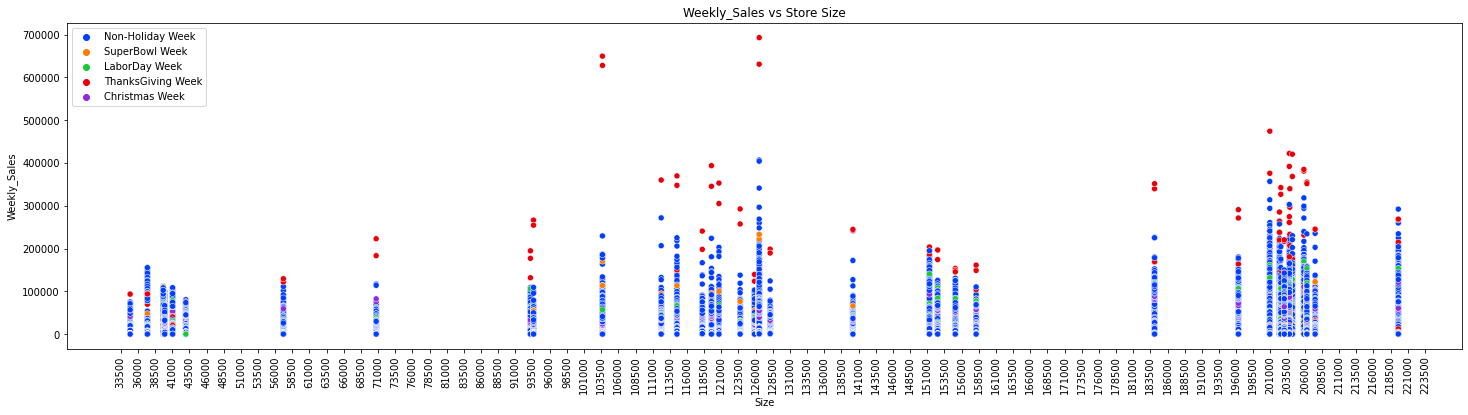

In [50]:
plt.figure(figsize=(25,6))
plt.title('Weekly_Sales vs Store Size')
# sns.set(style='whitegrid')
sns.scatterplot(x='Size', y='Weekly_Sales', hue='Holiday_ref', data=pd_train, palette='bright') # Weekly_Sales -> 0.3 =30L
plt.legend(loc='upper left')
plt.xticks(np.arange(33500,225000, step=2500), rotation=90)
plt.show()

Inference:
* Lower the Store Size, lower is the Sales when compared with higher Size Stores

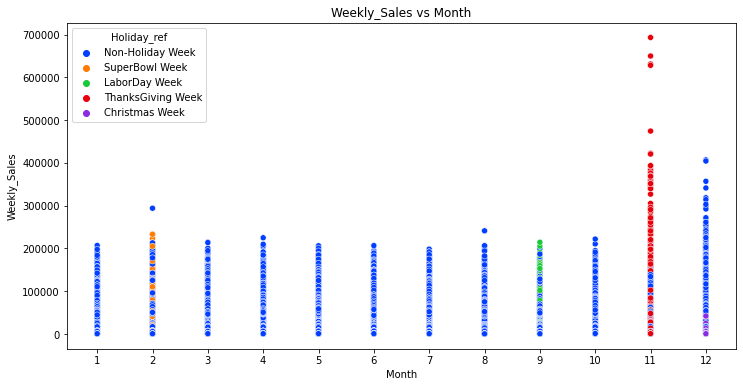

In [51]:
plt.figure(figsize=(12,6))
plt.title('Weekly_Sales vs Month')
# sns.set(style='whitegrid')
sns.scatterplot(x='Month', y='Weekly_Sales', hue='Holiday_ref', data=pd_train, palette='bright') # Weekly_Sales -> 0.3 =30L
plt.xticks(np.arange(1,13))
plt.show()

Inference:
* Sales is Higher during Nov and Dec

## Encoding

In [52]:
train_pp.show(2)

+-----+----+------------+--------+-----------+----------+---------+------------+----+-----+----+----------------+--------+
|Store|Dept|Weekly_Sales|    Size|Temperature|Fuel_Price|      CPI|Unemployment|Year|Month|Week|     Holiday_ref|Markdown|
+-----+----+------------+--------+-----------+----------+---------+------------+----+-----+----+----------------+--------+
|    1|   1|     24924.5|151315.0|      42.31|     2.572|211.09636|       8.106|2010|    2|   5|Non-Holiday Week|     0.0|
|    1|   1|    46039.49|151315.0|      38.51|     2.548|211.24217|       8.106|2010|    2|   6|  SuperBowl Week|     0.0|
+-----+----+------------+--------+-----------+----------+---------+------------+----+-----+----+----------------+--------+
only showing top 2 rows



In [53]:
holiday = train_pp.select("Holiday_ref").distinct().rdd.flatMap(lambda x: x).collect()
holiday

['LaborDay Week',
 'Non-Holiday Week',
 'SuperBowl Week',
 'Christmas Week',
 'ThanksGiving Week']

In [54]:
holiday_expr = [when(col("Holiday_ref") == ty, 1).otherwise(0).alias(ty) for ty in holiday]
holiday_expr

[Column<'CASE WHEN (Holiday_ref = LaborDay Week) THEN 1 ELSE 0 END AS `LaborDay Week`'>,
 Column<'CASE WHEN (Holiday_ref = Non-Holiday Week) THEN 1 ELSE 0 END AS `Non-Holiday Week`'>,
 Column<'CASE WHEN (Holiday_ref = SuperBowl Week) THEN 1 ELSE 0 END AS `SuperBowl Week`'>,
 Column<'CASE WHEN (Holiday_ref = Christmas Week) THEN 1 ELSE 0 END AS `Christmas Week`'>,
 Column<'CASE WHEN (Holiday_ref = ThanksGiving Week) THEN 1 ELSE 0 END AS `ThanksGiving Week`'>]

In [55]:
train_encoded = train_pp.select('Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Week', *holiday_expr, 'Markdown', 'Weekly_Sales')
train_encoded.show(2)

+-----+----+--------+-----------+----------+---------+------------+----+-----+----+-------------+----------------+--------------+--------------+-----------------+--------+------------+
|Store|Dept|    Size|Temperature|Fuel_Price|      CPI|Unemployment|Year|Month|Week|LaborDay Week|Non-Holiday Week|SuperBowl Week|Christmas Week|ThanksGiving Week|Markdown|Weekly_Sales|
+-----+----+--------+-----------+----------+---------+------------+----+-----+----+-------------+----------------+--------------+--------------+-----------------+--------+------------+
|    1|   1|151315.0|      42.31|     2.572|211.09636|       8.106|2010|    2|   5|            0|               1|             0|             0|                0|     0.0|     24924.5|
|    1|   1|151315.0|      38.51|     2.548|211.24217|       8.106|2010|    2|   6|            0|               0|             1|             0|                0|     0.0|    46039.49|
+-----+----+--------+-----------+----------+---------+------------+----+---

In [56]:
test_encoded = train_pp.select('Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Week', *holiday_expr, 'Markdown')
test_encoded.show(2)

+-----+----+--------+-----------+----------+---------+------------+----+-----+----+-------------+----------------+--------------+--------------+-----------------+--------+
|Store|Dept|    Size|Temperature|Fuel_Price|      CPI|Unemployment|Year|Month|Week|LaborDay Week|Non-Holiday Week|SuperBowl Week|Christmas Week|ThanksGiving Week|Markdown|
+-----+----+--------+-----------+----------+---------+------------+----+-----+----+-------------+----------------+--------------+--------------+-----------------+--------+
|    1|   1|151315.0|      42.31|     2.572|211.09636|       8.106|2010|    2|   5|            0|               1|             0|             0|                0|     0.0|
|    1|   1|151315.0|      38.51|     2.548|211.24217|       8.106|2010|    2|   6|            0|               0|             1|             0|                0|     0.0|
+-----+----+--------+-----------+----------+---------+------------+----+-----+----+-------------+----------------+--------------+-----------

# Model

## Vectors

In [57]:
train_encoded.columns[:-1]

['Store',
 'Dept',
 'Size',
 'Temperature',
 'Fuel_Price',
 'CPI',
 'Unemployment',
 'Year',
 'Month',
 'Week',
 'LaborDay Week',
 'Non-Holiday Week',
 'SuperBowl Week',
 'Christmas Week',
 'ThanksGiving Week',
 'Markdown']

In [58]:
vectorAssembler = VectorAssembler(inputCols = train_encoded.columns[:-1], outputCol = 'features')
train_vec = vectorAssembler.transform(train_encoded)
train_vec = train_vec.select(['features', 'Weekly_Sales'])
train_vec.show(3)

22/11/15 10:51:26 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+------------+
|            features|Weekly_Sales|
+--------------------+------------+
|[1.0,1.0,151315.0...|     24924.5|
|[1.0,1.0,151315.0...|    46039.49|
|[1.0,1.0,151315.0...|    41595.55|
+--------------------+------------+
only showing top 3 rows



## Train Test Split

In [59]:
splits = train_vec.randomSplit([0.7, 0.3], seed=1)
train_trn = splits[0]
train_tst = splits[1]

In [60]:
train_tst

DataFrame[features: vector, Weekly_Sales: float]

## Linear Regression

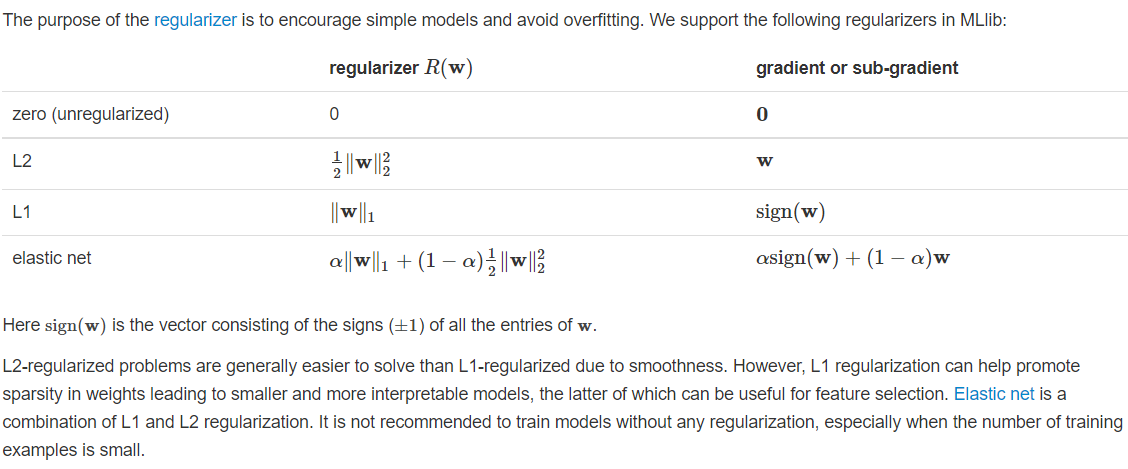

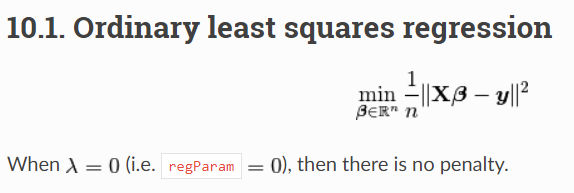

In [61]:
lr = LinearRegression(featuresCol='features', labelCol='Weekly_Sales', regParam=0, elasticNetParam=0)

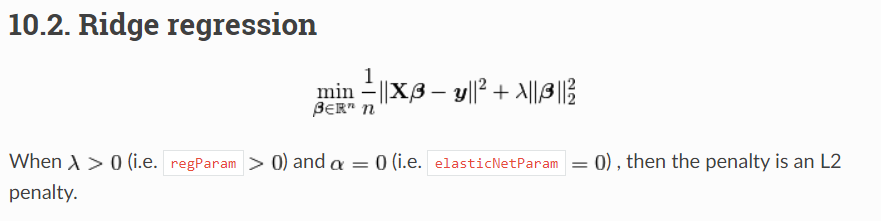

In [62]:
lr_ridge = LinearRegression(featuresCol='features', labelCol='Weekly_Sales', regParam=0.1, elasticNetParam=0.0) # L2 - Ridge Regression

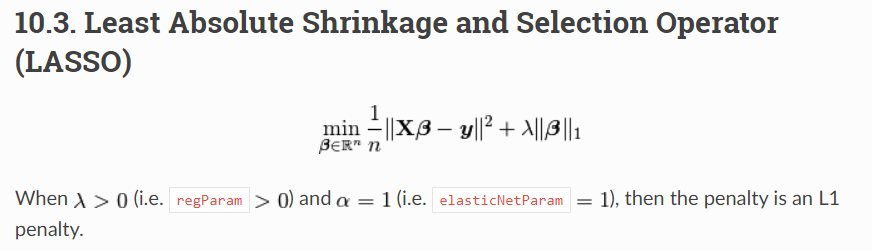

In [63]:
lr_lasso = LinearRegression(featuresCol='features', labelCol='Weekly_Sales', regParam=0.1, elasticNetParam=1.0)

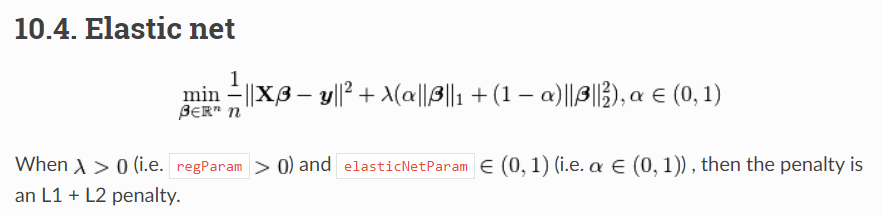

In [64]:
lr_en = LinearRegression(featuresCol='features', labelCol='Weekly_Sales', regParam=0.2, elasticNetParam=1.0)

## Training Model

In [65]:
lr_model = lr.fit(train_trn)

22/11/15 10:51:28 WARN Instrumentation: [3e7c97a5] regParam is zero, which might cause numerical instability and overfitting.
22/11/15 10:51:28 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/15 10:51:28 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/11/15 10:51:32 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/11/15 10:51:32 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
22/11/15 10:51:32 WARN Instrumentation: [3e7c97a5] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
22/11/15 10:51:33 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
22/11/15 10:51:33 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


In [66]:
lr_ridge_model = lr_ridge.fit(train_trn)

In [67]:
lr_lasso_model = lr_lasso.fit(train_trn)

In [68]:
lr_en_model = lr_en.fit(train_trn)

## Coefficients and Intercepts

In [69]:
print("Coefficients: {0} \nIntercepts: {1}".format(lr_model.coefficients, lr_model.intercept))
print("objectiveHistory: {0}".format(lr_model.summary.objectiveHistory))
lr_model.summary.residuals.show()
print("RMSE: %f" % lr_model.summary.rootMeanSquaredError)
print("r2: %f" % lr_model.summary.r2)

Coefficients: [-87.06293081902648,112.28644242585379,0.08517851988769168,23.22054588332322,431.1636103316297,-20.893944780056916,-198.70292555975834,-754.6680409815318,659.7942471322251,-120.23534044014785,-1017.676571255999,-386.224729563353,862.6416757361999,-2816.2075005956017,4869.132184785429,0.21743077233836633] 
Intercepts: 1520125.944070143
objectiveHistory: [0.5, 0.4590521659777044, 0.4571279658198507, 0.45671665254329963, 0.4566773829358547, 0.4566515987504297, 0.45665005425674476, 0.45664777369480813, 0.4566470404759536, 0.4566455987064232, 0.45664434390042896, 0.4566430664789679, 0.45664174628994314, 0.4566402474052148, 0.4566340050406802, 0.45662794935313766, 0.4566257262579364, 0.45662206363923385, 0.45662145629398065, 0.45662142587750776, 0.4566214249068211, 0.45662142472665945, 0.45662142468660616, 0.45662142468327727, 0.45662142468326306, 0.45662142468326306, 0.45662142468326306]


+------------------+
|         residuals|
+------------------+
| 5772.444625624688|
|24863.302588233724|
|  32453.0172901575|
| 29360.84926224989|
| 6922.459152594907|
| 19025.55276228441|
| 5667.324702897342|
|10354.186591003323|
| 41395.92970691947|
|17374.868377724895|
|  8974.73176649469|
| 4977.322024023393|
|10470.791344199097|
| 3658.316211285768|
| 8267.432867445517|
| 30816.33138576662|
| 5651.082730818773|
|13568.733023341512|
|32012.365093933186|
| 41889.78471301496|
+------------------+
only showing top 20 rows

RMSE: 21746.142352
r2: 0.086757


In [70]:
print("Coefficients: {0} \nIntercepts: {1}".format(lr_ridge_model.coefficients, lr_ridge_model.intercept))
print("objectiveHistory: {0}".format(lr_ridge_model.summary.objectiveHistory))
lr_ridge_model.summary.residuals.show()
print("RMSE: %f" % lr_ridge_model.summary.rootMeanSquaredError)
print("r2: %f" % lr_ridge_model.summary.r2)

Coefficients: [-87.06267606572777,112.28603691041938,0.08517808536082651,23.22003356958076,431.104399481525,-20.894027597600207,-198.69926620555356,-754.6850187780794,659.0350290298728,-120.0602457767051,-1017.4740546352331,-386.18007489314203,862.7366732548587,-2816.5665262492494,4868.845544802131,0.21743934961851574] 
Intercepts: 1520160.6972014585
objectiveHistory: [0.0]


+------------------+
|         residuals|
+------------------+
|5772.4480620045215|
|24863.317460140446|
|32452.986732089194|
|  29360.6926705644|
|6922.1183783982415|
| 19025.65382281551|
|  5667.15945558995|
| 10354.10484820255|
| 41395.81614284078|
|17374.973745727213|
| 8974.994146945886|
| 4977.337875983678|
|10471.059211818501|
| 3658.465647566365|
| 8267.706854545744|
|30816.264991787495|
| 5650.952539170627|
|  13568.4789638191|
|32012.317731114803|
|41889.545506599825|
+------------------+
only showing top 20 rows

RMSE: 21746.142353
r2: 0.086757


In [71]:
print("Coefficients: {0} \nIntercepts: {1}".format(lr_lasso_model.coefficients, lr_lasso_model.intercept))
print("objectiveHistory: {0}".format(lr_lasso_model.summary.objectiveHistory))
lr_lasso_model.summary.residuals.show()
print("RMSE: %f" % lr_lasso_model.summary.rootMeanSquaredError)
print("r2: %f" % lr_lasso_model.summary.r2)

Coefficients: [-87.00218864178161,112.28734860714405,0.08514436651769433,23.072567436764917,471.4198417740929,-20.793365180586154,-201.13685169446012,-790.6752889145905,564.5780793265645,-98.05860605737095,-1120.0238520561786,-524.0138273895728,746.8736105794486,-3022.1067206302564,4677.175208693959,0.2207484297294993] 
Intercepts: 1592589.6887318383
objectiveHistory: [0.5, 0.4859404645784765, 0.463843872241552, 0.4568612525246118, 0.4567723822928271, 0.456668427838566, 0.45666187409249037, 0.4566525457203721, 0.4566504459538317, 0.45664955526438183, 0.45664909186081415, 0.4566482010282025, 0.45664733186997564, 0.4566469334683748, 0.45664658765518346, 0.45664587409501656, 0.4566444803624128, 0.4566445066301646, 0.45663995157075365, 0.45663960546491505, 0.45663122774600196, 0.45662850434267854, 0.4566284329639171, 0.45662827716575755, 0.45662791912547607, 0.45662780040105905, 0.4566275456575998, 0.4566274406461848, 0.4566272871151077, 0.4566272126402163, 0.4566270813748088, 0.4566269373

+------------------+
|         residuals|
+------------------+
| 5795.762874737149|
| 24869.53675210895|
|32443.695757344365|
|29352.946151775774|
| 6901.510082416236|
|19032.534520903835|
| 5668.379098905483|
|10340.800839483505|
| 41396.24406653014|
|17374.736786643974|
| 9014.188993440242|
| 5014.030603090301|
| 10495.64288013149|
| 3707.713545032777|
| 8295.333452642895|
|30793.501900451956|
| 5625.872737314319|
| 13538.11852251133|
| 32007.00805860618|
|41844.462625527056|
+------------------+
only showing top 20 rows

RMSE: 21746.161372
r2: 0.086756


In [72]:
print("Coefficients: {0} \nIntercepts: {1}".format(lr_en_model.coefficients, lr_en_model.intercept))
print("objectiveHistory: {0}".format(lr_en_model.summary.objectiveHistory))
lr_en_model.summary.residuals.show()
print("RMSE: %f" % lr_en_model.summary.rootMeanSquaredError)
print("r2: %f" % lr_en_model.summary.r2)

Coefficients: [-87.05029136478996,112.28029281164912,0.08517368691295736,23.18390134277273,430.0545487493932,-20.884913896677038,-198.4513028254546,-755.2905085534294,641.0042783647352,-115.91883122307745,-1116.041266942356,-488.88577161207724,759.0207101134978,-2930.4126218818424,4754.983636813734,0.2176419193158968] 
Intercepts: 1521493.0888740919
objectiveHistory: [0.5, 0.48594136340554006, 0.4638460764995021, 0.45686393606266756, 0.4567751189296702, 0.4566711910207072, 0.4566646492570635, 0.45665534618446624, 0.4566532599618555, 0.4566523713206058, 0.45665191564235325, 0.45665102688284176, 0.45665015637246764, 0.4566497574219134, 0.45664941206373405, 0.45664869736245284, 0.45664729467483944, 0.4566473291829283, 0.45664302923411354, 0.4566427904139715, 0.45664273153624285, 0.45664249280221797, 0.4566353366919721, 0.45663284381812375, 0.4566325378755015, 0.456631537472855, 0.45663037103697907, 0.45662983806767315, 0.4566295875367127, 0.4566292810381062, 0.45662921895901043, 0.4566290

+------------------+
|         residuals|
+------------------+
| 5771.372749942122|
|24864.780740151415|
|32453.348678231472|
|29355.918120434275|
|6913.0864369783085|
|19027.736686926335|
| 5662.286185962614|
|10353.477166861994|
|  41392.2705339042|
|17377.208780932706|
|  8980.32088461006|
| 4976.949241354363|
|10477.205302668037|
| 3661.287833824521|
| 8274.046515986789|
|30814.513285278575|
| 5647.685168062337|
|13561.675673248246|
|32011.071373424493|
| 41883.76020407118|
+------------------+
only showing top 20 rows

RMSE: 21746.142979
r2: 0.086757


In [73]:
train_trn.describe().show()

+-------+------------------+
|summary|      Weekly_Sales|
+-------+------------------+
|  count|            295231|
|   mean|15990.740949119234|
| stddev| 22755.68021240548|
|    min|               0.0|
|    max|          693099.4|
+-------+------------------+



In [74]:
lr_predictions = lr_model.transform(train_tst)
lr_predictions.select("prediction","Weekly_Sales","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Weekly_Sales",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+------------+--------------------+
|        prediction|Weekly_Sales|            features|
+------------------+------------+--------------------+
|12025.273811219726|    21665.76|[1.0,1.0,151315.0...|
|12559.472576198401|     24924.5|[1.0,1.0,151315.0...|
|12289.671302795643|    19403.54|[1.0,1.0,151315.0...|
|13379.108298784588|    46788.75|[1.0,1.0,151315.0...|
|14210.347277397988|    36988.49|[1.0,1.0,151315.0...|
+------------------+------------+--------------------+
only showing top 5 rows



R Squared (R2) on test data = 0.0876355
